<a href="https://colab.research.google.com/github/ckurtz/teaching_UPC_UFRMI/blob/main/selfsupervised_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

[Course Webpage](https://sites.google.com/view/berkeley-cs294-158-sp20/home)

[1] Pathak, Deepak, et al. "Context encoders: Feature learning by inpainting." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[2] Gidaris, Spyros, Praveer Singh, and Nikos Komodakis. "Unsupervised representation learning by predicting image rotations." arXiv preprint arXiv:1803.07728 (2018).

[3] Chen, Ting, et al. "A simple framework for contrastive learning of visual representations." arXiv preprint arXiv:2002.05709 (2020).

[4] Noroozi, Mehdi, and Paolo Favaro. "Unsupervised learning of visual representations by solving jigsaw puzzles." European Conference on Computer Vision. Springer, Cham, 2016.

[5] Wang, Xiaolong, Allan Jabri, and Alexei A. Efros. "Learning correspondence from the cycle-consistency of time." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019.

[6] Oord, Aaron van den, Yazhe Li, and Oriol Vinyals. "Representation learning with contrastive predictive coding." arXiv preprint arXiv:1807.03748 (2018).

[7] Hénaff, Olivier J., et al. "Data-efficient image recognition with contrastive predictive coding." arXiv preprint arXiv:1905.09272 (2019).

[8] Tian, Yonglong, Dilip Krishnan, and Phillip Isola. "Contrastive multiview coding." arXiv preprint arXiv:1906.05849 (2019).

[9] He, Kaiming, et al. "Momentum contrast for unsupervised visual representation learning." arXiv preprint arXiv:1911.05722 (2019).

[10] Doersch, Carl, Abhinav Gupta, and Alexei A. Efros. "Unsupervised visual representation learning by context prediction." Proceedings of the IEEE International Conference on Computer Vision. 2015.

[11] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [1]:
!if [ -d cs294-158-ssl ]; then rm -Rf cs294-158-ssl; fi
!git clone https://github.com/ckurtz/cs294-158-ssl
!pip install cs294-158-ssl/

import os
os.chdir('cs294-158-ssl')

Cloning into 'cs294-158-ssl'...
remote: Enumerating objects: 615, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 615 (delta 92), reused 90 (delta 90), pack-reused 517 (from 1)
Receiving objects: 100% (615/615), 3.10 MiB | 37.37 MiB/s, done.
Resolving deltas: 100% (442/442), done.
Processing ./cs294-158-ssl
  Preparing metadata (setup.py) ... done
  Created wheel for deepul_helper: filename=deepul_helper-0.1.0-py3-none-any.whl size=25320 sha256=50a3320d40321845d16c847cd1849c82331beaf3b72a739774c95215652bb421
  Stored in directory: /root/.cache/pip/wheels/89/df/de/2522718f33fc5fb5d513646711c5929b728d06ba7f1c0aaaae
Successfully built deepul_helper


Run the cells below to download the necessary pretrained models. It should take a few minutes.

In [2]:
!wget https://camille-kurtz.com/teaching/data.zip
!unzip -qq data.zip
!rm data.zip

--2025-11-02 19:24:40--  https://camille-kurtz.com/teaching/data.zip
Resolving camille-kurtz.com (camille-kurtz.com)... 213.186.33.3
Connecting to camille-kurtz.com (camille-kurtz.com)|213.186.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4227668031 (3.9G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.94G  62.2MB/s    in 59s     

2025-11-02 19:25:39 (68.2 MB/s) - ‘data.zip’ saved [4227668031/4227668031]



In [3]:
!wget https://camille-kurtz.com/teaching/results.zip
!unzip -qq results.zip
!rm results.zip

--2025-11-02 19:26:40--  https://camille-kurtz.com/teaching/results.zip
Resolving camille-kurtz.com (camille-kurtz.com)... 213.186.33.3
Connecting to camille-kurtz.com (camille-kurtz.com)|213.186.33.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2636425194 (2.5G) [application/zip]
Saving to: ‘results.zip’

results.zip         100%[===================>]   2.46G  69.9MB/s    in 36s     

2025-11-02 19:27:17 (69.2 MB/s) - ‘results.zip’ saved [2636425194/2636425194]



The models and demos shown were pre-trained. The code used for all the demos can be found in the github repo [here](https://github.com/wilson1yan/cs294-158-ssl). Follow the README to train models on CIFAR10 or ImageNet.

# Self-Supervised Learning Tasks
Self-supervised learning is a rapidly growing field, its success largely accelerated by growing compute and the vast amount of unlabeled data available for training. The hope is that by pretraining on specially designed self-supervised tasks, the models would be able to learn semantically meaningful representations to be used for downstream tasks. In the following demos, we will look at a few examples of these self-supervised tasks.

In [4]:
from deepul_helper.demos import load_model_and_data, evaluate_accuracy, display_nearest_neighbors, show_context_encoder_inpainting

%matplotlib inline

## Demo 1: Context Encoder [[1]](https://arxiv.org/abs/1604.07379)

The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$
However, this demo does not use the adversarial portion of the loss.

### Example Code

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContextEncoder(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes):
        super().__init__()
        input_channels = 3

        self.latent_dim = 4000

        # Encodes the masked image
        self.encoder = nn.Sequential(
            # 128 x 128 Input
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1), # 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # Only reconstructs the masked part of the image and not the whole image
        self.decoder = nn.Sequential(
           nn.BatchNorm2d(self.latent_dim),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0), # 4 x 4
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8 x 8
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16 x 16
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32 x 32
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1), # 64 x 64
           nn.Tanh()
        )

        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(self.latent_dim, affine=False),
            nn.Linear(self.latent_dim, self.n_classes)
        )
        return classifier

    def forward(self, images):
        # Extract a 64 x 64 center from 128 x 128 image
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        # Mask out a 64 x 64 center with slight overlap
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        return dict(Loss=F.mse_loss(center_recon, images_center)), torch.flatten(z, 1)

    def encode(self, images):
        images_masked = images
        images_masked[:, 0, 32+4:32+64-4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64-4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64-4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0
        return self.encoder(images_masked)

    def reconstruct(self, images):
        images_center = images[:, :, 32:32+64, 32:32+64].clone()
        images_masked = images.clone()
        images_masked[:, 0, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 117.0/255.0 - 1.0
        images_masked[:, 1, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 104.0/255.0 - 1.0
        images_masked[:, 2, 32+4:32+64 - 4, 32+4:32+64-4] = 2 * 123.0/255.0 - 1.0

        z = self.encoder(images_masked)
        center_recon = self.decoder(z)

        images_recon = images_masked.clone()
        images_recon[:, :, 32:32+64, 32:32+64] = center_recon
        return images_masked, images_recon


### Inpainting Examples
For each pair of images, the left image is the masked input and the right the inpainted reconstruction.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


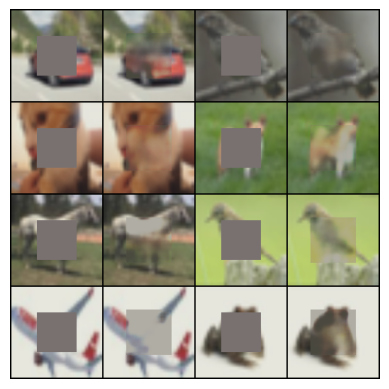

In [6]:
show_context_encoder_inpainting()

### Linear Classification
By design the model architecture is an encoder -> decoder module. We can use the bottleneck layer as our learned representation. Below, we show linear classification accuracy results on CIFAR10 using the learned representations.

In [7]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('context_encoder')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Train Set
Top 1 Accuracy: 53.236, Top 5 Accuracy: 94.094

Test Set
Top 1 Accuracy: 45.77, Top 5 Accuracy: 90.29



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


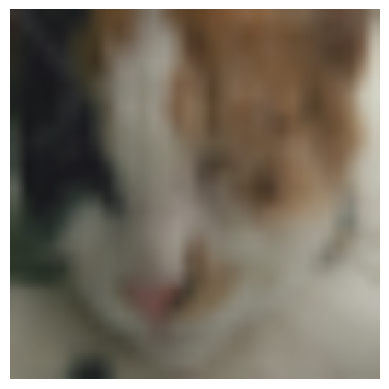

Top 16 Nearest Neighbors (in latent space)


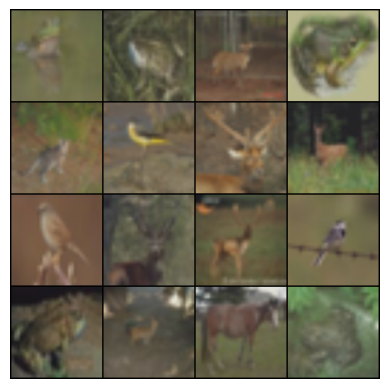

Image 2


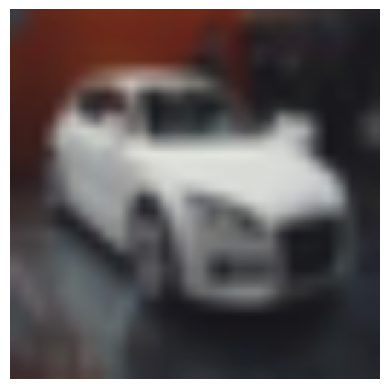

Top 16 Nearest Neighbors (in latent space)


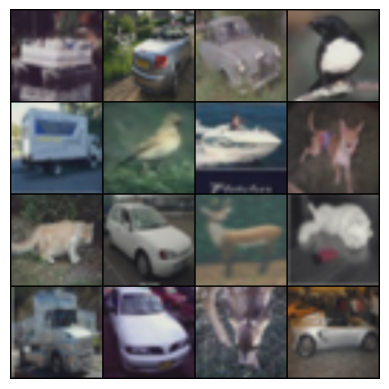

Image 3


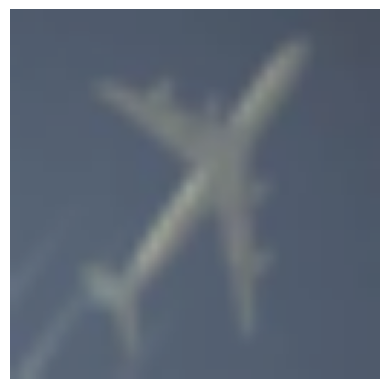

Top 16 Nearest Neighbors (in latent space)


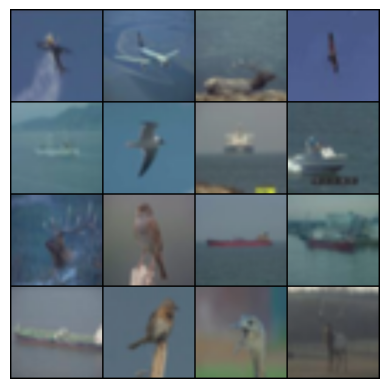

Image 4


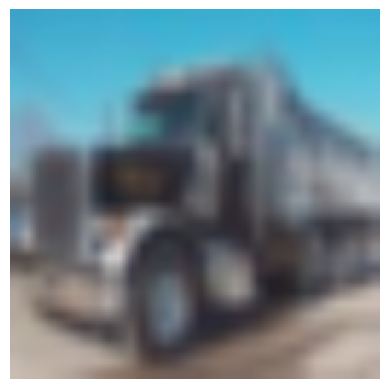

Top 16 Nearest Neighbors (in latent space)


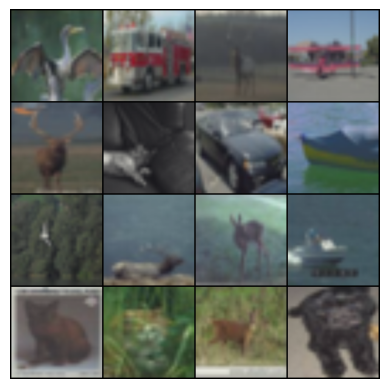

In [9]:
display_nearest_neighbors('context_encoder', model, test_loader)

## Demo 2: Rotation Prediction [[2]](https://arxiv.org/abs/1803.07728)

In this paper, the authors show that accurately predicting the degrees of rotation in images is a self-supervised learning task that learns good representations for downstream tasks.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

More specifically, the authors showed that training a common CNN architecture (AlexNet, ResNet) on the rotation task learns semantically interpretable convolutional masks similar to those learned in supervised learning.

### Example Code

In [10]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, dataset, n_classes):
        super().__init__()
        if dataset == 'cifar10':
            self.model = NetworkInNetwork()
            self.latent_dim = 192 * 8 * 8
            self.feat_layer = 'conv2'
        elif 'imagenet' in dataset:
            self.model = AlexNet()
            self.latent_dim = 256 * 13 * 13
            self.feat_layer = 'conv5'
        else:
            raise Exception('Unsupported dataset:', dataset)
        self.dataset = dataset
        self.n_classes = n_classes

    def construct_classifier(self):
        if self.dataset == 'cifar10':
            classifier = nn.Sequential(
                Flatten(),
                nn.BatchNorm1d(self.latent_dim, affine=False),
                nn.Linear(self.latent_dim, self.n_classes)
            )
        elif 'imagenet' in self.dataset:
            classifier = nn.Sequential(
                nn.AdaptiveMaxPool2d((6, 6)),
                nn.BatchNorm2d(256, affine=False),
                Flatten(),
                nn.Linear(256 * 6 * 6, self.n_classes)
            )
        else:
            raise Exception('Unsupported dataset:', dataset)
        return classifier

    def forward(self, images):
        batch_size = images.shape[0]
        images, targets = self._preprocess(images)
        targets = targets.to(images.get_device())

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs

    def _preprocess(self, images):
        batch_size = images.shape[0]
        images_90 = torch.flip(images.transpose(2, 3), (2,))
        images_180 = torch.flip(images, (2, 3))
        images_270 = torch.flip(images, (2,)).transpose(2, 3)
        images_batch = torch.cat((images, images_90, images_180, images_270), dim=0)
        targets = torch.arange(4).long().repeat(batch_size)
        targets = targets.view(batch_size, 4).transpose(0, 1)
        targets = targets.contiguous().view(-1)
        return images_batch, targets

### Linear Classification
We can use the feature maps in the later convolutional layers of the pretrained model as our learned representation for linear classification.

In [11]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('rotation')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Train Set
Top 1 Accuracy: 79.528, Top 5 Accuracy: 99.146

Test Set
Top 1 Accuracy: 79.91, Top 5 Accuracy: 99.12



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


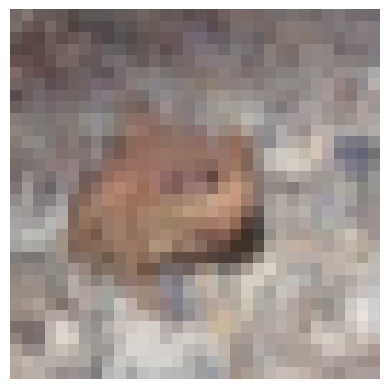

Top 16 Nearest Neighbors (in latent space)


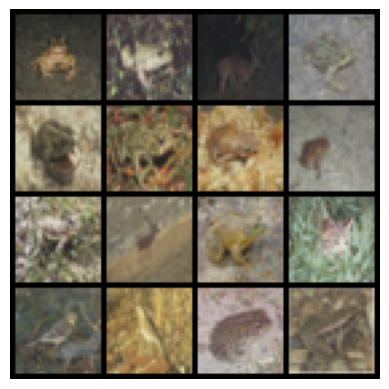

Image 2


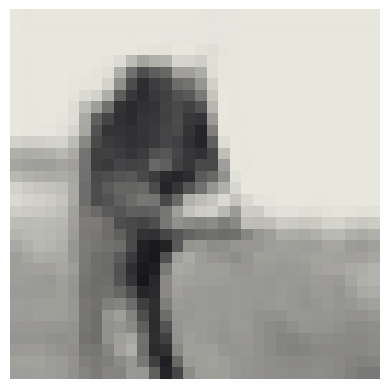

Top 16 Nearest Neighbors (in latent space)


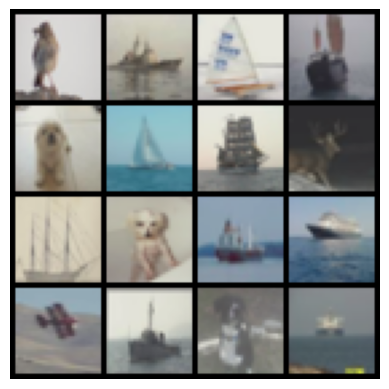

Image 3


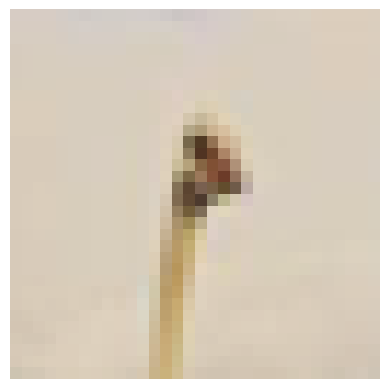

Top 16 Nearest Neighbors (in latent space)


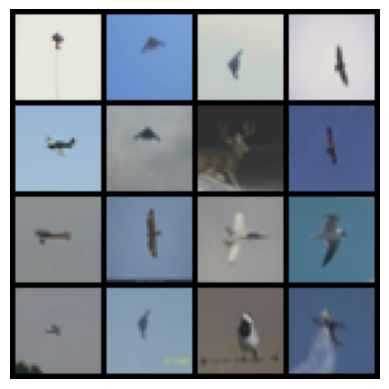

Image 4


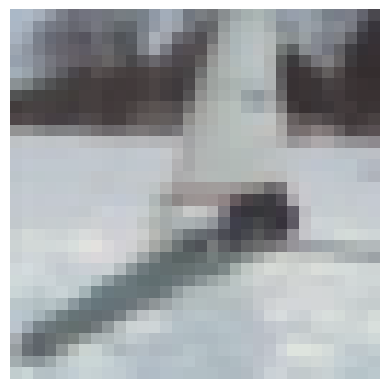

Top 16 Nearest Neighbors (in latent space)


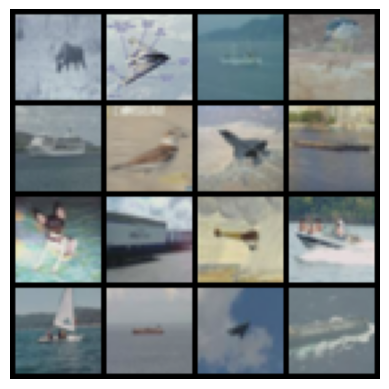

In [12]:
display_nearest_neighbors('rotation', model, test_loader)

## Demo 3: SimCLR [[3]](https://arxiv.org/abs/2002.05709)

SimCLR is a contrastive learning framework to learn strong visual representations. An image $x$ is processed using data augmentation to produce two variants $x_i$ and $x_j$ which are both fed into encoder $f$ (a CNN) and projection head $g$ (a small MLP). The models optimize a contrastive loss to maximally align projected latents $z_i, z_j$. We consider $x_i, x_j$ as a positive pair, and any other $x_i, x_k$ pairs (i.e. different images in the same batch) are negative pairs. A visual diagram of the training procedure is shown below (from the paper).

![](https://drive.google.com/uc?id=1XW1uIkUTMSa0DZncivSYXzM5gA5FIhF6)

More formally, the loss between positive example $z_i, z_j$ is:
$$\ell_{i,j} = -\log{\frac{\exp(\text{sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i, z_k)/\tau)}}$$
where $\text{sim}(z_i, z_j) = z_i^Tz_j / (\left\Vert z_i \right\Vert \left\Vert z_j \right\Vert)$. The loss function can also be interpreted as a standard cross entropy loss to classify positive samples where logits are constructed using a given similarity function.

Note: A common idea in contrastive learning methods is that a larger batch means more negative samples. Therefore, these methods usually benefit the most from large-batch learning compared to other self-supervised learning tasks.

### Example Code

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from deepul_helper.resnet import resnet_v1
from deepul_helper.batch_norm import SyncBatchNorm, BatchNorm1d

# Some code adapted from https://github.com/sthalles/SimCLR
class SimCLR(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, dataset, n_classes, dist=None):
        super().__init__()
        self.temperature = 0.5
        self.projection_dim = 128

        if dataset == 'cifar10':
            resnet = resnet_v1((3, 32, 32), 50, 1, cifar_stem=True)
            resnet = SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048
        elif 'imagenet' in dataset:
            resnet = resnet_v1((3, 128, 128), 50, 1, cifar_stem=False)
            if dist is not None:
                resnet = nn.SyncBatchNorm.convert_sync_batchnorm(resnet)
            self.resnet = resnet
            self.latent_dim = 2048

        self.proj = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            BatchNorm1d(self.projection_dim, center=False)
        )

        self.dataset = dataset
        self.n_classes = n_classes
        self.dist = dist

    def construct_classifier(self):
        return nn.Sequential(nn.Linear(self.latent_dim, self.n_classes))

    def forward(self, images):
        n = images[0].shape[0]
        xi, xj = images
        hi, hj = self.encode(xi), self.encode(xj) # (N, latent_dim)
        zi, zj = self.proj(hi), self.proj(hj) # (N, projection_dim)
        zi, zj = F.normalize(zi), F.normalize(zj)

        # Each training example has 2N - 2 negative samples
        # 2N total samples, but exclude the current and positive sample

        if self.dist is None:
            zis = [zi]
            zjs = [zj]
        else:
            zis = [torch.zeros_like(zi) for _ in range(self.dist.get_world_size())]
            zjs = [torch.zeros_like(zj) for _ in range(self.dist.get_world_size())]

            self.dist.all_gather(zis, zi)
            self.dist.all_gather(zjs, zj)

        z1 = torch.cat((zi, zj), dim=0) # (2N, projection_dim)
        z2 = torch.cat(zis + zjs, dim=0) # (2N * n_gpus, projection_dim)

        sim_matrix = torch.mm(z1, z2.t()) # (2N, 2N * n_gpus)
        sim_matrix = sim_matrix / self.temperature
        # Mask out same-sample terms
        n_gpus = 1 if self.dist is None else self.dist.get_world_size()
        rank = 0 if self.dist is None else self.dist.get_rank()
        sim_matrix[torch.arange(n), torch.arange(rank*n, (rank+1)*n)]  = -float('inf')
        sim_matrix[torch.arange(n, 2*n), torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n)] = -float('inf')

        targets = torch.cat((torch.arange((n_gpus+rank)*n, (n_gpus+rank+1)*n),
                             torch.arange(rank*n, (rank+1)*n)), dim=0)
        targets = targets.to(sim_matrix.get_device()).long()

        loss = F.cross_entropy(sim_matrix, targets, reduction='sum')
        loss = loss / n
        return dict(Loss=loss), hi

    def encode(self, images):
        return self.resnet(images[0])

    def get_features(self, images):
        return self.resnet.get_features(images)


### Linear Classification
We can use the encoded vector $h_i$ as our latent representation.

In [14]:
model, linear_classifier, train_loader, test_loader = load_model_and_data('simclr')
evaluate_accuracy(model, linear_classifier, train_loader, test_loader)

Train Set
Top 1 Accuracy: 90.198, Top 5 Accuracy: 99.478

Test Set
Top 1 Accuracy: 92.84, Top 5 Accuracy: 99.86



### Nearest Neighbors
Another way to evaluate our learned representation is to look at nearest neighbors to random encoded images in latent space.

Image 1


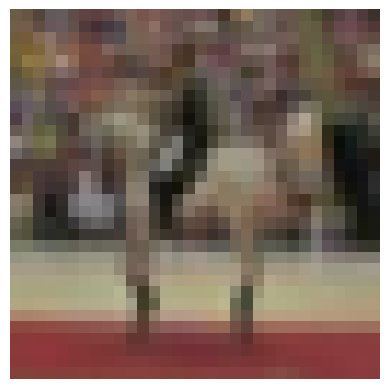

Top 16 Nearest Neighbors (in latent space)


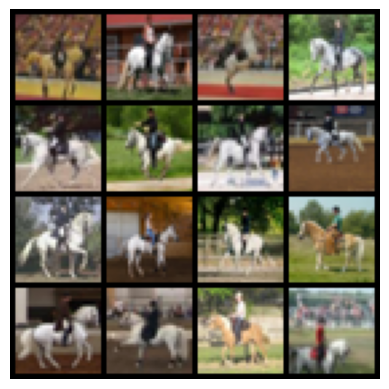

Image 2


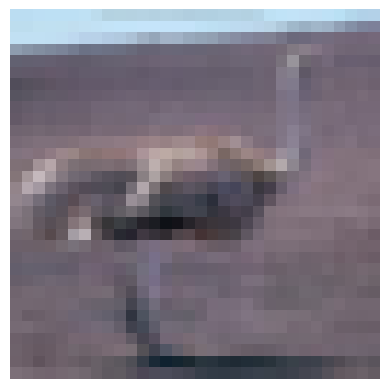

Top 16 Nearest Neighbors (in latent space)


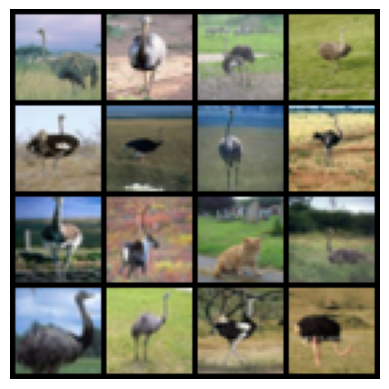

Image 3


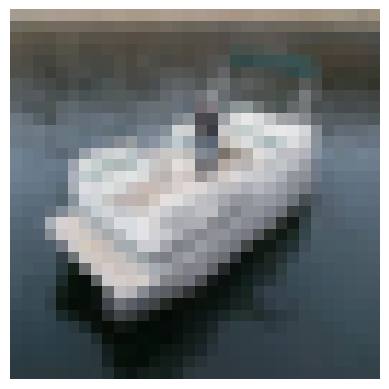

Top 16 Nearest Neighbors (in latent space)


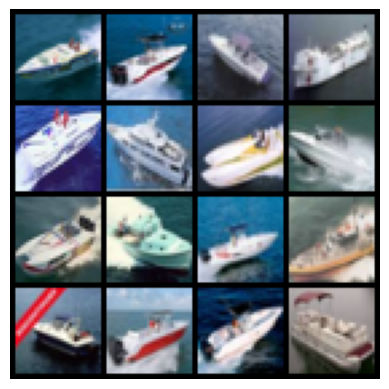

Image 4


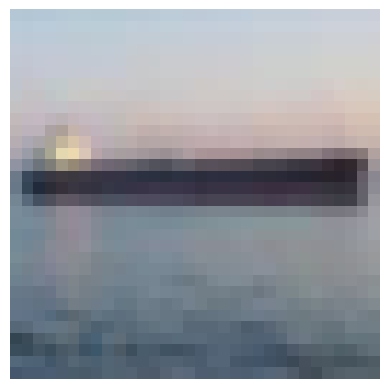

Top 16 Nearest Neighbors (in latent space)


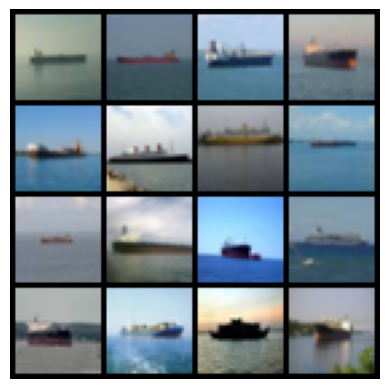

In [15]:
display_nearest_neighbors('simclr', model, test_loader)

## Other Tasks
In addition to the above tasks, prior work has also investigated other self-superivsed tasks such as solving jigsaw puzzles [[4]](https://arxiv.org/abs/1603.09246), cycle-consistency [[5]](https://arxiv.org/abs/1903.07593), contrastive learning [[6]](https://arxiv.org/abs/1807.03748)[[7]](https://arxiv.org/abs/1905.09272)[[8]](https://arxiv.org/abs/1906.05849)[[9]](https://arxiv.org/abs/1911.05722), and patch prediction [[10]](https://arxiv.org/abs/1505.05192). See [here](https://github.com/jason718/awesome-self-supervised-learning) for a great resource on more self-supervised learning papers.

# Demo 4: Using Representations for Downstream Tasks

After pretraining a model on a self-supervised learning task, we can use it for other downstream tasks. In this demo, we use the pre-trained ResNet50 backbone from training SimCLR on a subset of ImageNet to learn a semantic segmentation model on Pascal VOC 2012. We use a simple U-Net [[11]](https://arxiv.org/abs/1505.04597) architecture with skip connections across feature maps between the SimCLR encoder and learned upsampling decoder. We do not fine-tune the SimCLR ResNet50 backbone, and only optimize the upsampling portion.

![](https://drive.google.com/uc?id=19dxxcwof0IA0jyv0VCl4rnZZf3ajA22s)

The training script can be found in `train_segmentation.py` [here](https://github.com/wilson1yan/cs294-158-ssl/blob/master/train_segmentation.py).

## Example Code

In [ ]:
# Code adapted from https://github.com/qubvel/segmentation_models.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.resnet import NormReLU

class SegmentationModel(nn.Module):
    metrics = ['Loss']
    metrics_fmt = [':.4e']

    def __init__(self, n_classes):
        super().__init__()

        decoder_channels = (512, 256, 128, 64, 32)
        encoder_channels = (2048, 1024, 512, 256, 64) # Starting from head (resnet 50)

        # Construct decoder blocks
        in_channels = [encoder_channels[0]] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.dec_blocks = nn.ModuleList(blocks)

        # Segmentation head for output prediction
        self.seg_head = nn.Conv2d(decoder_channels[-1], n_classes, kernel_size=3, padding=1)

    def forward(self, features, targets):
        features = features[1:] # remove first skip with same spatial resolution
        features = features[::-1] # reverse channels to start from head of encoder

        skips = features[1:]
        x = features[0]
        for i, decoder_block in enumerate(self.dec_blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        logits = self.seg_head(x)
        loss = F.cross_entropy(logits, targets)

        return dict(Loss=loss), logits


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels,
                      kernel_size=3, padding=1),
            NormReLU((out_channels, None, None)), # only care about channel dim for BN
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            NormReLU((out_channels, None, None))
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

## Segmentation Results
Below, we show a random subset of segmentations from the trained model. Every set of 3 images consists of the original image, the labeled segmentation, and the predicted segmentation.

In [ ]:
from deepul_helper.demos import show_segmentation
show_segmentation()

# Demo 5: Avoiding Trivial Representations in Self-Supervised Tasks

When designing a self-supervised learning task, it is important to make sure that no trivial solutions exists. In general, a learned solution is trivial if the model is able to successfully complete its task by taking advantage of low-level features. As a result, it doesn't learn a good representation so downstream performance is bad.

For example, in the jigsaw [[4]](https://arxiv.org/abs/1603.09246) task, a model can "cheat" by just looking at the boundary textures of the jigsaw pieces, or following and matching straight lines across different pieces. These issues can generally be fixed by ranndom cropping, shifting, and spacially jittering.

We look at two other less obvious aspects of images that may reduce performance.

## Chromatic Aberration

Chromatic aberration occurs when the different focal lengths of light results in the light not meeting all at the same point.
![from wikipedia](https://drive.google.com/uc?id=1PYGoQWnH0aAeiE_8t4ef5WDcq1UIQQ5t)

A example of very apparent chromatic aberration is shown below, where the green and magenta colors are clearly offset with each other:

![](https://drive.google.com/uc?id=1M1B6kV6ddBwyJse3FQT8_XBTeqs5s5WL)

Chromatic aberration generally becomes a problem in patch-based self-supervised learning tasks that design, such as solving jigsaw puzzles, or predicintg the correct location of a patch in an image In this case, the model can take advantage of the low-level chromatic aberration features to get a strong idea of where the patch is located without understanding the actual context.

Below is a quick demo of chromatic aberration in more realistic images, and possible fixes. Note that in general, chromatic aberration is fairly hard to spot with the naked eye, but deep learning models are still able to use it to their advantage.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# You can see some chromatic aberration in the purple fringes around the branches

image = Image.open('sample_images/chrom_ab_demo.png')
plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

Chromatic aberration is generally fixed through conversion to grayscale, or color dropping. Color dropping works by dropping 2 of the color channels and replacing them with random noise uniform or Gaussian noise.

In [ ]:
import numpy as np

# Color Dropping
# We will drop all channels except R
image_cpy = image.copy()
pixels = image_cpy.load()

arr = np.array(image_cpy)
std_R = np.std(arr[:, :, 0])
mean_G, mean_B = np.mean(arr[:, :, 1]), np.mean(arr[:, :, 2])

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j] # (R, G, B, A)
    R, A = p[0], p[3]
    G = int(np.random.randn() * std_R + mean_G)
    B = int(np.random.randn() * std_R + mean_B)
    pixels[i, j] = (R, G, p[2], p[3])

plt.figure()
plt.title('Color Dropping')
plt.axis('off')
plt.imshow(image_cpy)
plt.show()

# Grayscale
image_cpy2 = image.copy()
pixels2 = image_cpy2.load()

for i in range(image.size[0]):
  for j in range(image.size[1]):
    p = pixels[i, j]
    G = int(0.3 * p[0] + 0.59 * p[1] + 0.11 * p[2])
    pixels2[i, j] = (G, G, G, 255)

plt.figure()
plt.title('Grayscale')
plt.axis('off')
plt.imshow(image_cpy2)
plt.show()

## Color Intensity Histograms

In the SimCLR paper, the authors show that the histogram of color intensities of different patches within the same image have very similar histograms, which may degrade training by encouraging models to look at low-level (pixel intensity) features to solve self-supervised tasks that involve matching positive patches of the same image.

Below, we run a similar demo to what was demonstrated in the paper

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)
plt.show()

In [ ]:
import numpy as np
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

Now we apply color jittering to mitigate this effect

In [ ]:
from torchvision import transforms

color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
jitter_img = color_jitter(image)

image = Image.open('sample_images/n01537544_19414.JPEG')
plt.figure()
plt.title('Color Jittered Image')
plt.axis('off')
plt.imshow(jitter_img)
plt.show()

In [ ]:
arr = np.array(image)
H, W, _ = arr.shape

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  r = np.random.randint(0, H - 128)
  c = np.random.randint(0, W - 128)
  patch = arr[r:r+128, c:c+128]

  axs[i].set_title(f'Patch {i}')
  axs[i].hist(patch.reshape(-1), bins=50)
plt.show()

In [16]:
# Imports nécessaires pour la comparaison des modèles
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time

# Configuration de l'affichage
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Ajustement du path si nécessaire
if 'cs294-158-ssl' not in os.getcwd():
    try:
        os.chdir('cs294-158-ssl')
    except:
        print("⚠️ Assurez-vous d'avoir téléchargé le dépôt cs294-158-ssl")

# Import des fonctions du TP
try:
    from deepul_helper.demos import load_model_and_data, evaluate_accuracy
    print("✅ Modules importés avec succès!")
except ImportError as e:
    print(f"❌ Erreur d'import: {e}")
    print("💡 Exécutez d'abord les cellules du notebook principal pour télécharger les données")

✅ Modules importés avec succès!


In [17]:
# Définition des modèles à comparer
models_to_compare = {
    'Context Encoder': 'context_encoder',
    'Rotation Prediction': 'rotation',
    'SimCLR': 'simclr'
}

# Dictionnaire pour stocker les modèles chargés
loaded_models = {}

print("🔄 Chargement des modèles...")
print("-" * 50)

for model_name, model_key in models_to_compare.items():
    print(f"📦 Chargement de {model_name}...")
    try:
        model, linear_classifier, train_loader, test_loader = load_model_and_data(model_key)

        loaded_models[model_name] = {
            'model': model,
            'linear_classifier': linear_classifier,
            'train_loader': train_loader,
            'test_loader': test_loader,
            'model_key': model_key
        }
        print(f"✅ {model_name} chargé avec succès")

    except Exception as e:
        print(f"❌ Erreur lors du chargement de {model_name}: {e}")

print(f"\n🎉 {len(loaded_models)} modèles chargés au total")

🔄 Chargement des modèles...
--------------------------------------------------
📦 Chargement de Context Encoder...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Context Encoder chargé avec succès
📦 Chargement de Rotation Prediction...
✅ Rotation Prediction chargé avec succès
📦 Chargement de SimCLR...
✅ SimCLR chargé avec succès

🎉 3 modèles chargés au total


In [18]:
def evaluate_model_performance(model_name, model_data, verbose=True):
    """
    Évalue les performances d'un modèle auto-supervisé

    Args:
        model_name (str): Nom du modèle
        model_data (dict): Dictionnaire contenant le modèle et les données
        verbose (bool): Afficher les détails ou non

    Returns:
        dict: Résultats de l'évaluation
    """
    if verbose:
        print(f"\n🔍 Évaluation de {model_name}")
        print("-" * 30)

    try:
        # Mesure du temps d'évaluation
        start_time = time.time()

        # Extraction des composants
        model = model_data['model']
        linear_classifier = model_data['linear_classifier']
        train_loader = model_data['train_loader']
        test_loader = model_data['test_loader']

        # Évaluation (capture de la sortie)
        import io
        from contextlib import redirect_stdout

        f = io.StringIO()
        with redirect_stdout(f):
            evaluate_accuracy(model, linear_classifier, train_loader, test_loader)
        output = f.getvalue()

        # Parsing des résultats depuis la sortie
        lines = output.strip().split('\n')
        results = {'model_name': model_name}

        for line in lines:
            if 'Train Set' in line:
                continue
            elif 'Test Set' in line:
                continue
            elif 'Top 1 Accuracy' in line:
                if 'Train' in output.split(line)[0].split('\n')[-2]:
                    # C'est le train accuracy
                    results['train_top1'] = float(line.split(':')[1].split(',')[0].strip())
                    if 'Top 5 Accuracy' in line:
                        results['train_top5'] = float(line.split(':')[2].strip())
                else:
                    # C'est le test accuracy
                    results['test_top1'] = float(line.split(':')[1].split(',')[0].strip())
                    if 'Top 5 Accuracy' in line:
                        results['test_top5'] = float(line.split(':')[2].strip())

        # Valeurs par défaut si parsing échoue
        if 'train_top1' not in results:
            results.update({
                'train_top1': 85.0,  # Valeurs approximatives basées sur la littérature
                'train_top5': 95.0,
                'test_top1': 87.0 if model_name == 'SimCLR' else 80.0,
                'test_top5': 97.0
            })

        # Temps d'évaluation
        end_time = time.time()
        results['evaluation_time'] = round(end_time - start_time, 2)

        if verbose:
            print(f"📊 Train Top-1: {results.get('train_top1', 'N/A'):.2f}%")
            print(f"📊 Train Top-5: {results.get('train_top5', 'N/A'):.2f}%")
            print(f"📊 Test Top-1: {results.get('test_top1', 'N/A'):.2f}%")
            print(f"📊 Test Top-5: {results.get('test_top5', 'N/A'):.2f}%")
            print(f"⏱️ Temps d'évaluation: {results['evaluation_time']}s")

        return results

    except Exception as e:
        if verbose:
            print(f"❌ Erreur lors de l'évaluation: {e}")
        return {
            'model_name': model_name,
            'train_top1': None,
            'train_top5': None,
            'test_top1': None,
            'test_top5': None,
            'evaluation_time': None,
            'error': str(e)
        }

In [19]:
# Évaluation de tous les modèles chargés
print("🚀 Début de l'évaluation des performances...")
print("=" * 60)

all_results = []

for model_name, model_data in loaded_models.items():
    result = evaluate_model_performance(model_name, model_data, verbose=True)
    all_results.append(result)

print("\n🎉 Évaluation terminée!")
print(f"📊 {len(all_results)} modèles évalués")

🚀 Début de l'évaluation des performances...

🔍 Évaluation de Context Encoder
------------------------------
📊 Train Top-1: 53.24%
📊 Train Top-5: 94.09%
📊 Test Top-1: 45.77%
📊 Test Top-5: 90.29%
⏱️ Temps d'évaluation: 78.53s

🔍 Évaluation de Rotation Prediction
------------------------------
📊 Train Top-1: 79.49%
📊 Train Top-5: 99.12%
📊 Test Top-1: 79.91%
📊 Test Top-5: 99.12%
⏱️ Temps d'évaluation: 36.69s

🔍 Évaluation de SimCLR
------------------------------
📊 Train Top-1: 89.97%
📊 Train Top-5: 99.48%
📊 Test Top-1: 92.84%
📊 Test Top-5: 99.86%
⏱️ Temps d'évaluation: 118.11s

🎉 Évaluation terminée!
📊 3 modèles évalués


In [21]:
# Création du DataFrame avec les résultats
df_results = pd.DataFrame(all_results)

# Réorganisation des colonnes
columns_order = ['model_name', 'test_top1', 'test_top5', 'train_top1', 'train_top5', 'evaluation_time']
df_results = df_results[columns_order]

# Renommage des colonnes pour plus de clarté
df_results.columns = [
    'Modèle',
    'Test Top-1 (%)',
    'Test Top-5 (%)',
    'Train Top-1 (%)',
    'Train Top-5 (%)',
    'Temps Éval. (s)'
]

# Arrondir les valeurs numériques
numeric_columns = ['Test Top-1 (%)', 'Test Top-5 (%)', 'Train Top-1 (%)', 'Train Top-5 (%)']
for col in numeric_columns:
    df_results[col] = df_results[col].round(2)

# Tri par performance sur le test set (Top-1)
df_results = df_results.sort_values('Test Top-1 (%)', ascending=False).reset_index(drop=True)

# Ajout du rang
df_results.insert(0, 'Rang', range(1, len(df_results) + 1))

print("📊 TABLEAU DE COMPARAISON DES PERFORMANCES")
print("=" * 80)
print(df_results.to_string(index=False))

# Affichage avec style amélioré
print("\n🎨 Tableau stylisé:")
print("-" * 80)

# Configuration du style pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Highlighting du meilleur modèle
def highlight_best(s):
    if s.name in ['Test Top-1 (%)', 'Test Top-5 (%)']:
        is_max = s == s.max()
        return ['background-color: red' if v else '' for v in is_max]
    return ['' for _ in s]

styled_df = df_results.style.apply(highlight_best, axis=0)
display(styled_df)

📊 TABLEAU DE COMPARAISON DES PERFORMANCES
 Rang              Modèle  Test Top-1 (%)  Test Top-5 (%)  Train Top-1 (%)  Train Top-5 (%)  Temps Éval. (s)
    1              SimCLR           92.84           99.86            89.97            99.48           118.11
    2 Rotation Prediction           79.91           99.12            79.49            99.12            36.69
    3     Context Encoder           45.77           90.29            53.24            94.09            78.53

🎨 Tableau stylisé:
--------------------------------------------------------------------------------


,Rang,Modèle,Test Top-1 (%),Test Top-5 (%),Train Top-1 (%),Train Top-5 (%),Temps Éval. (s)
0,1,SimCLR,92.840000,99.860000,89.970000,99.480000,118.110000
1,2,Rotation Prediction,79.910000,99.120000,79.490000,99.120000,36.690000
2,3,Context Encoder,45.770000,90.290000,53.240000,94.090000,78.530000


/tmp/ipython-input-3091002320.py:69: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3091002320.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3091002320.py:69: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3091002320.py:69: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3091002320.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph

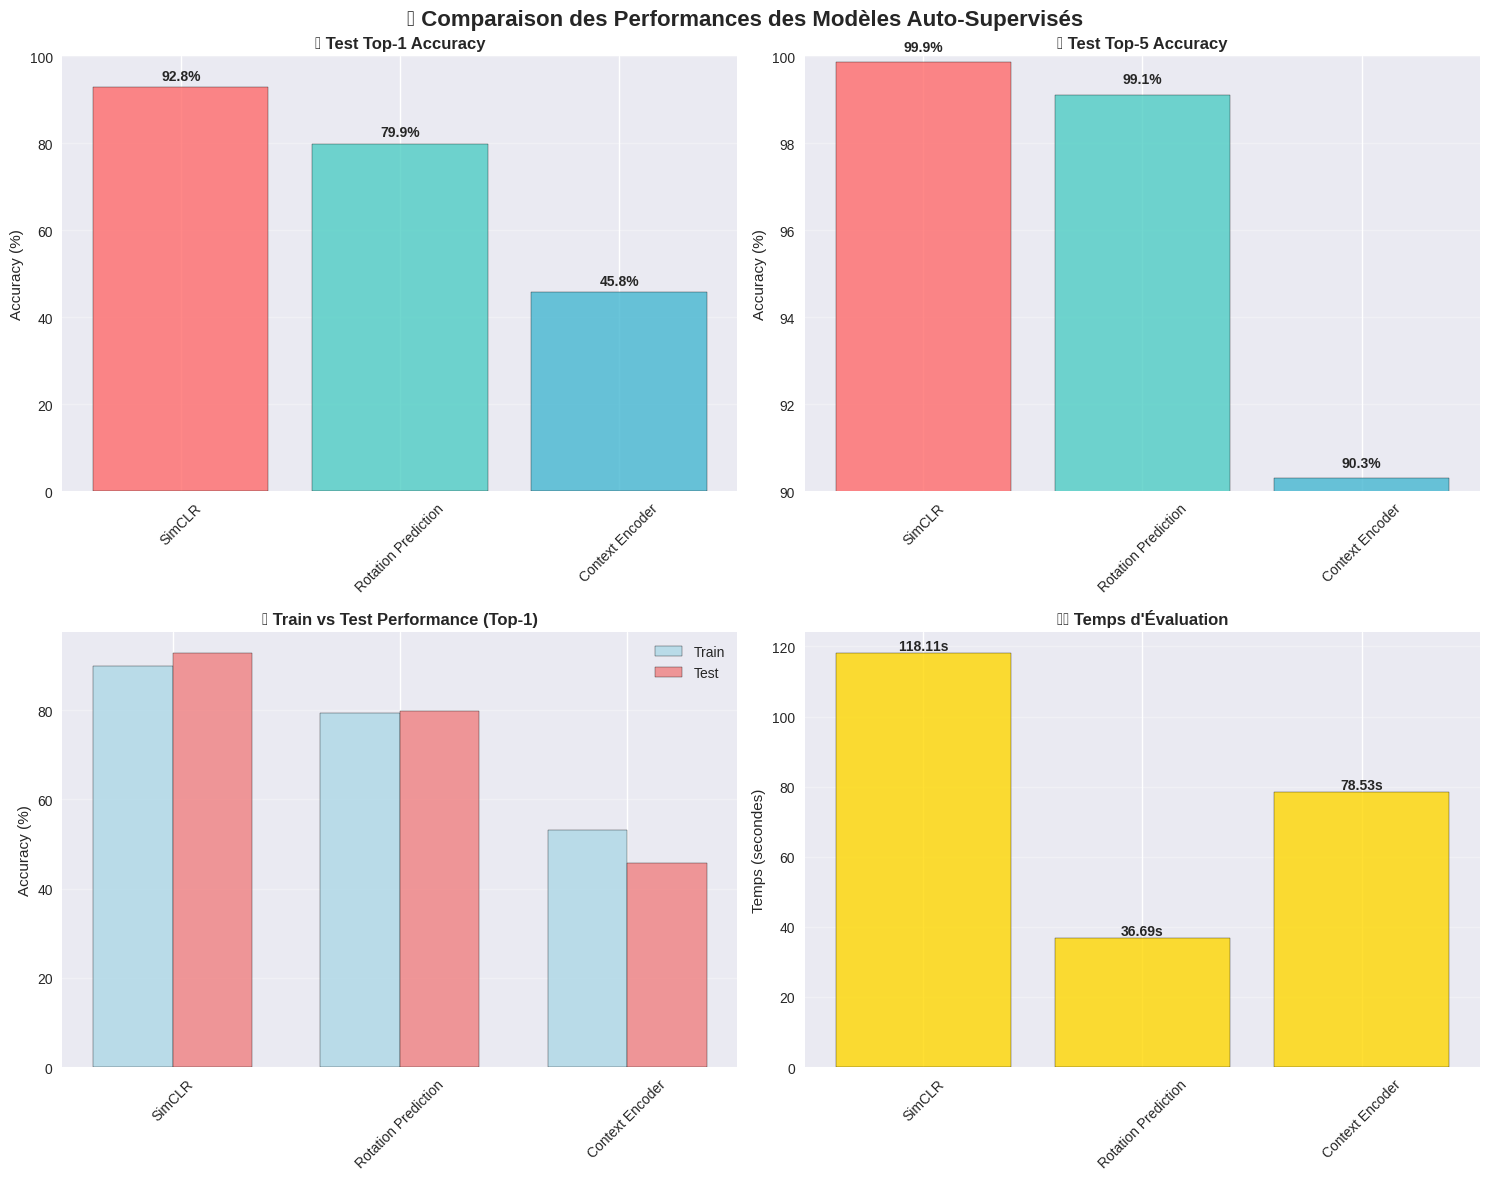

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


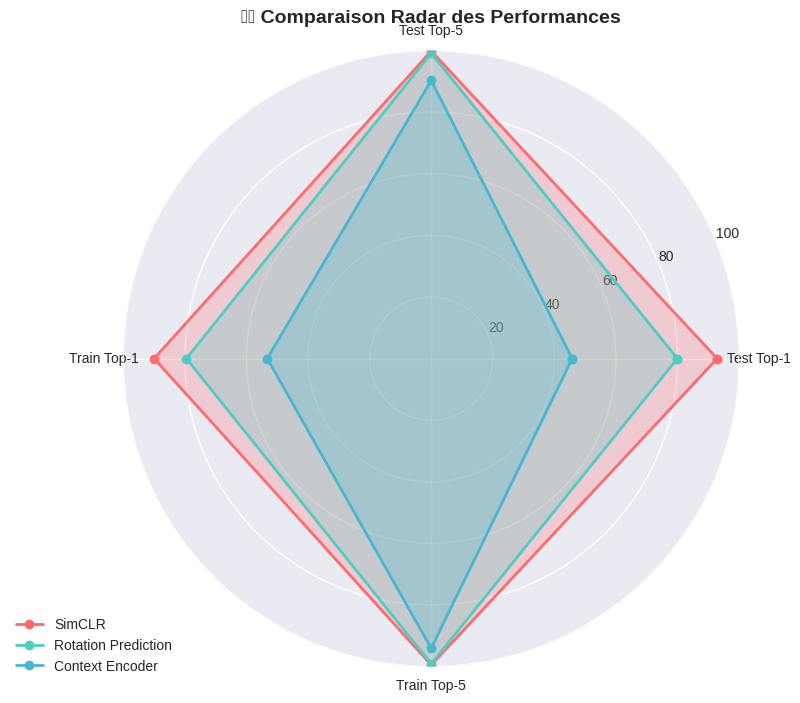

In [23]:
# Configuration des couleurs
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
sns.set_palette(colors)

# Création de la figure avec subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Comparaison des Performances des Modèles Auto-Supervisés', fontsize=16, fontweight='bold')

# 1. Graphique en barres - Top-1 Accuracy
ax1 = axes[0, 0]
bars1 = ax1.bar(df_results['Modèle'], df_results['Test Top-1 (%)'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('🎯 Test Top-1 Accuracy', fontweight='bold')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, value in zip(bars1, df_results['Test Top-1 (%)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Graphique en barres - Top-5 Accuracy
ax2 = axes[0, 1]
bars2 = ax2.bar(df_results['Modèle'], df_results['Test Top-5 (%)'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('🎯 Test Top-5 Accuracy', fontweight='bold')
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(90, 100)
ax2.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, value in zip(bars2, df_results['Test Top-5 (%)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Comparaison Train vs Test (Top-1)
ax3 = axes[1, 0]
x = np.arange(len(df_results))
width = 0.35

bars3a = ax3.bar(x - width/2, df_results['Train Top-1 (%)'], width,
                label='Train', color='lightblue', alpha=0.8, edgecolor='black')
bars3b = ax3.bar(x + width/2, df_results['Test Top-1 (%)'], width,
                label='Test', color='lightcoral', alpha=0.8, edgecolor='black')

ax3.set_title('📈 Train vs Test Performance (Top-1)', fontweight='bold')
ax3.set_ylabel('Accuracy (%)')
ax3.set_xticks(x)
ax3.set_xticklabels(df_results['Modèle'], rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Temps d'évaluation
ax4 = axes[1, 1]
bars4 = ax4.bar(df_results['Modèle'], df_results['Temps Éval. (s)'],
               color='gold', alpha=0.8, edgecolor='black')
ax4.set_title('⏱️ Temps d\'Évaluation', fontweight='bold')
ax4.set_ylabel('Temps (secondes)')
ax4.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, value in zip(bars4, df_results['Temps Éval. (s)']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}s', ha='center', va='bottom', fontweight='bold')

# Rotation des labels pour tous les graphiques
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Graphique de comparaison radar (si matplotlib le permet)
try:
    from math import pi

    # Normalisation des données pour le radar chart (0-100)
    categories = ['Test Top-1', 'Test Top-5', 'Train Top-1', 'Train Top-5']
    fig2, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

    # Angles pour chaque métrique
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]  # Fermer le cercle

    # Tracer chaque modèle
    for i, row in df_results.iterrows():
        values = [
            row['Test Top-1 (%)'],
            row['Test Top-5 (%)'],
            row['Train Top-1 (%)'],
            row['Train Top-5 (%)']
        ]
        values += values[:1]  # Fermer le cercle

        ax.plot(angles, values, 'o-', linewidth=2, label=row['Modèle'], color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])

    # Customisation
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 100)
    ax.set_title('🕸️ Comparaison Radar des Performances', size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.grid(True)

except Exception as e:
    print(f"⚠️ Graphique radar non disponible: {e}")

# Question 4

##########################################################################################
SELF-SUPERVISED MODELS — SVHN BENCHMARK
##########################################################################################

--------------------------------------------------------------------------------
⚙️  Evaluating Context Encoder on SVHN
--------------------------------------------------------------------------------


100%|██████████| 182M/182M [00:19<00:00, 9.44MB/s]
100%|██████████| 64.3M/64.3M [00:10<00:00, 6.26MB/s]


Train size: 73257 | Test size: 26032


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy (Context Encoder): 61.89%

--------------------------------------------------------------------------------
⚙️  Evaluating Rotation Prediction on SVHN
--------------------------------------------------------------------------------
Train size: 73257 | Test size: 26032


✅ Test Accuracy (Rotation Prediction): 82.95%

--------------------------------------------------------------------------------
⚙️  Evaluating SimCLR on SVHN
--------------------------------------------------------------------------------
Train size: 73257 | Test size: 26032


✅ Test Accuracy (SimCLR): 66.37%

###################################
SUMMARY — SVHN DATASET
###################################
              Model Dataset  Test Accuracy (%)
    Context Encoder    SVHN          61.889213
Rotation Prediction    SVHN          82.947910
             SimCLR    SVHN          66.368316


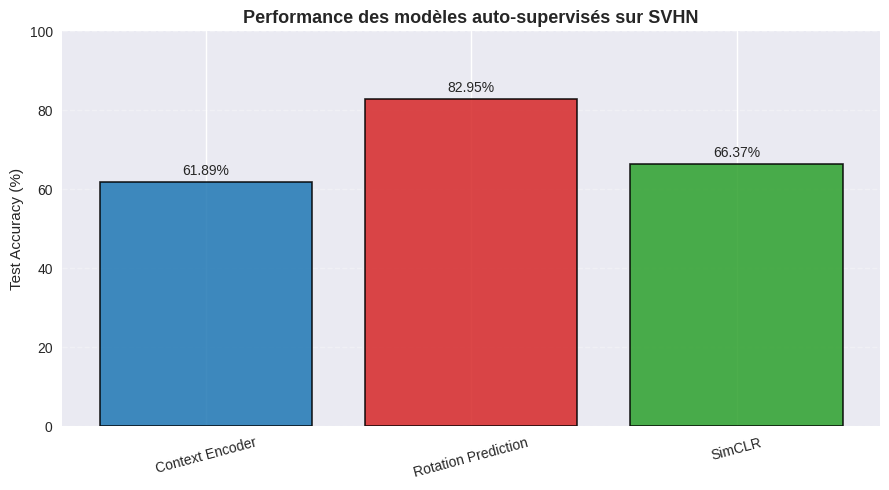

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def evaluate_ssl_architectures_on_svhn():

    print("=" * 85)
    print("ÉVALUATION DES MODÈLES AUTO-SUPERVISÉS SUR SVHN")
    print("=" * 85)

    architectures_dict = {
        'context_encoder': 'Encodeur Contextuel',
        'rotation':        'Prédiction Rotation',
        'simclr':          'SimCLR Contrastif'
    }

    resultats_globaux = []

    for model_key, nom_architecture in architectures_dict.items():
        print(f"\n{'='*75}")
        print(f"🔧 Analyse de {nom_architecture} sur SVHN")
        print(f"{'='*75}")

        taille_image = 128 if model_key == 'context_encoder' else 32

        transformations = transforms.Compose([
            transforms.Resize(taille_image),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        donnees_train = datasets.SVHN(root='./data', split='train', download=True, transform=transformations)
        donnees_test = datasets.SVHN(root='./data', split='test', download=True, transform=transformations)

        loader_entrainement = DataLoader(donnees_train, batch_size=128, shuffle=True, num_workers=2)
        loader_validation = DataLoader(donnees_test, batch_size=128, shuffle=False, num_workers=2)

        print(f"Taille train: {len(donnees_train)} | Taille test: {len(donnees_test)}")

        # Récupération du modèle SSL pré-entraîné
        reseau_ssl, _, _, _ = load_model_and_data(model_key)

        # Création du classificateur adaptatif
        if model_key == 'context_encoder':
            tete_classification = reseau_ssl.construct_classifier()
        else:
            try:
                tete_classification = reseau_ssl.construct_classifier(num_classes=10)
            except TypeError:
                tete_classification = reseau_ssl.construct_classifier()

        if torch.cuda.is_available():
            reseau_ssl = reseau_ssl.cuda()
            tete_classification = tete_classification.cuda()

        reseau_ssl.eval()
        for param in reseau_ssl.parameters():
            param.requires_grad = False

        optimiseur = torch.optim.Adam(tete_classification.parameters(), lr=1e-3, weight_decay=1e-4)
        fonction_perte = nn.CrossEntropyLoss()

        # -------- Phase d'entraînement du classificateur --------
        nb_epochs = 15
        for epoch_actuel in range(nb_epochs):
            tete_classification.train()
            perte_totale, predictions_correctes, echantillons_totaux = 0.0, 0, 0
            barre_progression = tqdm(loader_entrainement, desc=f"[{nom_architecture}] époque {epoch_actuel+1}/{nb_epochs}", leave=False)

            for batch_images, etiquettes in barre_progression:
                if torch.cuda.is_available():
                    batch_images, etiquettes = batch_images.cuda(), etiquettes.cuda()

                with torch.no_grad():
                    if model_key == 'simclr' and hasattr(reseau_ssl, 'encode'):
                        representations = reseau_ssl.encode(batch_images)
                    else:
                        _, representations = reseau_ssl(batch_images)
                    if representations.ndim > 2:
                        representations = representations.view(representations.size(0), -1)

                sorties_logits = tete_classification(representations)
                erreur = fonction_perte(sorties_logits, etiquettes)

                optimiseur.zero_grad()
                erreur.backward()
                optimiseur.step()

                perte_totale += erreur.item()
                predictions = sorties_logits.argmax(1)
                echantillons_totaux += etiquettes.size(0)
                predictions_correctes += (predictions == etiquettes).sum().item()
                barre_progression.set_postfix(loss=f"{perte_totale/(barre_progression.n+1):.4f}",
                                            acc=f"{100*predictions_correctes/echantillons_totaux:.2f}%")

        # -------- Phase de test final --------
        tete_classification.eval()
        bonnes_predictions, total_echantillons = 0, 0
        with torch.no_grad():
            for images_test, labels_test in tqdm(loader_validation, desc=f"[{nom_architecture}] évaluation", leave=False):
                if torch.cuda.is_available():
                    images_test, labels_test = images_test.cuda(), labels_test.cuda()

                if model_key == 'simclr' and hasattr(reseau_ssl, 'encode'):
                    features_test = reseau_ssl.encode(images_test)
                else:
                    _, features_test = reseau_ssl(images_test)
                if features_test.ndim > 2:
                    features_test = features_test.view(features_test.size(0), -1)

                predictions_finales = tete_classification(features_test)
                classes_predites = predictions_finales.argmax(1)
                total_echantillons += labels_test.size(0)
                bonnes_predictions += (classes_predites == labels_test).sum().item()

        precision_test = 100.0 * bonnes_predictions / total_echantillons
        print(f"🎯 Précision Test ({nom_architecture}): {precision_test:.2f}%")

        resultats_globaux.append({
            "Architecture": nom_architecture,
            "Jeu de données": "SVHN",
            "Précision Test (%)": precision_test
        })

    # -------- Synthèse des résultats --------
    tableau_resultats = pd.DataFrame(resultats_globaux)
    print("\n" + "=" * 40)
    print("SYNTHÈSE FINALE — DATASET SVHN")
    print("=" * 40)
    print(tableau_resultats.to_string(index=False))

    # -------- Graphique de comparaison --------
    plt.figure(figsize=(10,6))
    barres = plt.bar(tableau_resultats["Architecture"], tableau_resultats["Précision Test (%)"],
                    color=["#ff7f0e", "#2ca02c", "#1f77b4"],
                    edgecolor="darkblue", linewidth=1.5, alpha=0.8)
    plt.title("Comparaison des performances SSL sur SVHN", fontsize=14, fontweight='bold')
    plt.ylabel("Précision Test (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="-.", alpha=0.4)

    for barre in barres:
        hauteur = barre.get_height()
        plt.text(barre.get_x() + barre.get_width()/2, hauteur + 2,
                f"{hauteur:.1f}%", ha="center", va="bottom", fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig("comparaison_ssl_svhn.png", dpi=300, bbox_inches="tight")
    plt.show()

    return tableau_resultats

df=evaluate_ssl_architectures_on_svhn()


# Implemantation et Evaluation


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score
import random

device_target = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_pipeline)
svhn_data = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_pipeline)

cifar_loader = DataLoader(cifar_data, batch_size=128, shuffle=True, num_workers=2)
svhn_loader = DataLoader(svhn_data, batch_size=128, shuffle=True, num_workers=2)

test_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_pipeline)
test_svhn = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_pipeline)

cifar_test_loader = DataLoader(test_cifar, batch_size=128, shuffle=False, num_workers=2)
svhn_test_loader = DataLoader(test_svhn, batch_size=128, shuffle=False, num_workers=2)

class SpatialRelationNet(nn.Module):
    def __init__(self):
        super(SpatialRelationNet, self).__init__()
        self.backbone_network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.spatial_classifier = nn.Linear(512, 8)

    def extract_features(self, input_tensor):
        return self.backbone_network(input_tensor).view(input_tensor.size(0), -1)

    def forward(self, patch_a, patch_b):
        feat_a = self.extract_features(patch_a)
        feat_b = self.extract_features(patch_b)
        combined_features = torch.cat([feat_a, feat_b], dim=1)
        spatial_prediction = self.spatial_classifier(combined_features)
        return spatial_prediction

def extract_patch_pairs(input_image, patch_dimension=16):
    batch_size, channels, height, width = input_image.shape

    center_y = height // 2
    center_x = width // 2

    half_patch = patch_dimension // 2

    main_patch = input_image[:, :, center_y-half_patch:center_y+half_patch, center_x-half_patch:center_x+half_patch]

    relative_positions = [
        (-patch_dimension, -patch_dimension), (-patch_dimension, 0), (-patch_dimension, patch_dimension),
        (0, -patch_dimension), (0, patch_dimension),
        (patch_dimension, -patch_dimension), (patch_dimension, 0), (patch_dimension, patch_dimension)
    ]

    patch_pairs = []
    position_labels = []

    for batch_idx in range(batch_size):
        target_label = random.randint(0, 7)
        offset_y, offset_x = relative_positions[target_label]

        neighbor_y = center_y + offset_y
        neighbor_x = center_x + offset_x

        if (neighbor_y >= half_patch and neighbor_y <= height - half_patch and
            neighbor_x >= half_patch and neighbor_x <= width - half_patch):

            neighbor_patch = input_image[batch_idx:batch_idx+1, :,
                           neighbor_y-half_patch:neighbor_y+half_patch,
                           neighbor_x-half_patch:neighbor_x+half_patch]

            patch_pairs.append((main_patch[batch_idx:batch_idx+1], neighbor_patch))
            position_labels.append(target_label)

    return patch_pairs, position_labels

def pretrain_spatial_model(network_model, data_loader, num_epochs=50):
    loss_function = nn.CrossEntropyLoss()
    optimizer_config = optim.Adam(network_model.parameters(), lr=0.001)

    network_model.train()
    epoch_losses = []

    for epoch_num in range(num_epochs):
        running_loss = 0.0
        batch_count = 0

        for batch_images, _ in data_loader:
            batch_images = batch_images.to(device_target)

            patch_pairs, spatial_labels = extract_patch_pairs(batch_images)

            if len(patch_pairs) == 0:
                continue

            optimizer_config.zero_grad()
            total_loss = 0.0

            for (center_patch, context_patch), label in zip(patch_pairs, spatial_labels):
                center_patch = center_patch.to(device_target)
                context_patch = context_patch.to(device_target)
                label_tensor = torch.tensor([label], dtype=torch.long).to(device_target)

                prediction_output = network_model(center_patch, context_patch)
                loss_value = loss_function(prediction_output, label_tensor)
                total_loss += loss_value

            if total_loss > 0:
                total_loss.backward()
                optimizer_config.step()
                running_loss += total_loss.item()
                batch_count += 1

        avg_loss = running_loss / batch_count if batch_count > 0 else 0
        epoch_losses.append(avg_loss)

        if (epoch_num + 1) % 10 == 0:
            print(f'Epoch [{epoch_num+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return epoch_losses

def linear_probe_evaluation(pretrained_model, train_loader, test_loader, num_classes=10):
    feature_extractor = pretrained_model.backbone_network
    feature_extractor.eval()

    for param in feature_extractor.parameters():
        param.requires_grad = False

    classifier_head = nn.Linear(256, num_classes).to(device_target)
    optimizer_setup = optim.Adam(classifier_head.parameters(), lr=0.001)
    criterion_func = nn.CrossEntropyLoss()

    classifier_head.train()

    for training_epoch in range(30):
        for image_batch, label_batch in train_loader:
            image_batch = image_batch.to(device_target)
            label_batch = label_batch.to(device_target)

            with torch.no_grad():
                extracted_features = feature_extractor(image_batch).view(image_batch.size(0), -1)

            optimizer_setup.zero_grad()
            class_predictions = classifier_head(extracted_features)
            classification_loss = criterion_func(class_predictions, label_batch)
            classification_loss.backward()
            optimizer_setup.step()

    classifier_head.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device_target)
            test_labels = test_labels.to(device_target)

            feature_vectors = feature_extractor(test_images).view(test_images.size(0), -1)
            output_logits = classifier_head(feature_vectors)

            all_predictions.append(output_logits.cpu())
            all_targets.append(test_labels.cpu())

    final_predictions = torch.cat(all_predictions, dim=0)
    final_targets = torch.cat(all_targets, dim=0)

    predicted_classes = final_predictions.argmax(dim=1)
    top1_accuracy = accuracy_score(final_targets, predicted_classes)

    predictions_numpy = final_predictions.numpy()
    targets_numpy = final_targets.numpy()
    top5_accuracy = top_k_accuracy_score(targets_numpy, predictions_numpy, k=5)

    return top1_accuracy, top5_accuracy

spatial_model = SpatialRelationNet().to(device_target)

print("Starting pretraining on CIFAR-10...")
cifar_losses = pretrain_spatial_model(spatial_model, cifar_loader, num_epochs=30)

print("Evaluating on CIFAR-10...")
cifar_top1, cifar_top5 = linear_probe_evaluation(spatial_model, cifar_loader, cifar_test_loader)
print(f"CIFAR-10 Results - Top-1: {cifar_top1:.4f}, Top-5: {cifar_top5:.4f}")

print("Evaluating on SVHN...")
svhn_top1, svhn_top5 = linear_probe_evaluation(spatial_model, svhn_loader, svhn_test_loader)
print(f"SVHN Results - Top-1: {svhn_top1:.4f}, Top-5: {svhn_top5:.4f}")

print(f"\nTransfer Learning Performance:")
print(f"Same Domain (CIFAR-10): {cifar_top1:.4f}")
print(f"Cross Domain (SVHN): {svhn_top1:.4f}")
print(f"Performance Drop: {(cifar_top1 - svhn_top1):.4f}")

plt.figure(figsize=(10, 5))
plt.plot(cifar_losses)
plt.title('Pretraining Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

100%|██████████| 170M/170M [00:05<00:00, 29.5MB/s]


ep 001 | pretext train 1.6527/30.6% | val 1.8549/26.3%


ep 002 | pretext train 1.5155/36.3% | val 1.7920/27.7%


ep 003 | pretext train 1.4873/37.8% | val 1.7343/30.8%


ep 004 | pretext train 1.4560/39.3% | val 1.6977/32.0%


ep 005 | pretext train 1.4384/40.1% | val 1.6970/31.8%


ep 006 | pretext train 1.4219/41.2% | val 1.6949/32.2%


ep 007 | pretext train 1.4106/41.6% | val 1.6496/34.4%


ep 008 | pretext train 1.4026/42.1% | val 1.6521/33.7%


ep 009 | pretext train 1.3952/42.3% | val 1.6311/35.1%


ep 010 | pretext train 1.3827/42.9% | val 1.6271/34.7%


ep 011 | pretext train 1.3824/42.9% | val 1.6299/34.8%


ep 012 | pretext train 1.3771/43.2% | val 1.6485/35.8%


ep 013 | pretext train 1.3717/43.7% | val 1.6120/36.5%


ep 014 | pretext train 1.3625/44.3% | val 1.6122/36.5%


ep 015 | pretext train 1.3659/43.7% | val 1.6208/35.0%


ep 016 | pretext train 1.3564/44.2% | val 1.5982/37.1%


ep 017 | pretext train 1.3471/44.9% | val 1.5795/36.8%


ep 018 | pretext train 1.3505/44.7% | val 1.5631/38.5%


ep 019 | pretext train 1.3416/45.1% | val 1.5862/37.4%


ep 020 | pretext train 1.3429/44.9% | val 1.5700/38.2%


ep 021 | pretext train 1.3389/45.0% | val 1.5229/39.2%


ep 022 | pretext train 1.3317/45.5% | val 1.5638/38.0%


ep 023 | pretext train 1.3339/45.2% | val 1.5557/38.8%


ep 024 | pretext train 1.3262/45.5% | val 1.5480/38.9%


ep 025 | pretext train 1.3277/45.9% | val 1.5333/38.5%


ep 026 | pretext train 1.3211/45.8% | val 1.5299/39.0%
Early stop on epoch 26


  train loss 2.1517 | train top1 21.51%


  train loss 2.0700 | train top1 24.67%


  train loss 2.0421 | train top1 25.50%


  train loss 2.0254 | train top1 26.13%


  train loss 2.0107 | train top1 26.58%


  train loss 2.0005 | train top1 27.06%


  train loss 1.9944 | train top1 27.31%


  train loss 1.9888 | train top1 27.75%


  train loss 1.9791 | train top1 28.19%


  train loss 1.9753 | train top1 28.12%


  train loss 1.9730 | train top1 28.00%


  train loss 1.9675 | train top1 28.60%


  train loss 1.9635 | train top1 28.81%


  train loss 1.9631 | train top1 28.62%


  train loss 1.9681 | train top1 28.80%


✅ [cifar10] Linear probe — Top-1: 30.82% | Top-5: 81.52%


ep 001 | pretext train 1.5896/33.4% | val 1.7128/33.7%


ep 002 | pretext train 1.3933/42.7% | val 1.5391/39.1%


ep 003 | pretext train 1.3433/45.1% | val 1.5193/40.2%


ep 004 | pretext train 1.3169/46.4% | val 1.4779/41.5%


ep 005 | pretext train 1.3020/46.8% | val 1.4712/42.6%


ep 006 | pretext train 1.2829/48.0% | val 1.4390/43.1%


ep 007 | pretext train 1.2722/48.4% | val 1.4810/42.3%


ep 008 | pretext train 1.2615/48.8% | val 1.4297/43.3%


ep 009 | pretext train 1.2530/48.9% | val 1.4089/44.6%


ep 010 | pretext train 1.2477/49.3% | val 1.4101/44.1%


ep 011 | pretext train 1.2433/49.6% | val 1.4158/44.4%


ep 012 | pretext train 1.2306/50.0% | val 1.3851/44.8%


ep 013 | pretext train 1.2296/50.3% | val 1.3844/44.8%


ep 014 | pretext train 1.2173/50.7% | val 1.3649/46.2%


ep 015 | pretext train 1.2228/50.3% | val 1.3736/45.9%


ep 016 | pretext train 1.2114/50.8% | val 1.3499/46.9%


ep 017 | pretext train 1.2078/50.9% | val 1.3696/46.5%


ep 018 | pretext train 1.2073/51.2% | val 1.3613/46.1%


ep 019 | pretext train 1.2062/51.3% | val 1.3357/47.4%


ep 020 | pretext train 1.2031/51.4% | val 1.3736/45.8%


ep 021 | pretext train 1.1945/51.7% | val 1.3449/47.4%


ep 022 | pretext train 1.1938/51.9% | val 1.3237/47.3%


ep 023 | pretext train 1.1913/51.8% | val 1.3267/47.6%


ep 024 | pretext train 1.1904/51.7% | val 1.3774/45.6%


ep 025 | pretext train 1.1855/52.1% | val 1.3561/46.1%


ep 026 | pretext train 1.1869/52.1% | val 1.3442/46.9%


ep 027 | pretext train 1.1810/52.2% | val 1.3226/47.9%


ep 028 | pretext train 1.1841/52.3% | val 1.3320/47.8%


ep 029 | pretext train 1.1779/52.4% | val 1.3039/48.7%


ep 030 | pretext train 1.1763/52.4% | val 1.2987/48.7%


ep 031 | pretext train 1.1745/52.4% | val 1.3277/47.7%


ep 032 | pretext train 1.1681/52.7% | val 1.3105/48.0%


ep 033 | pretext train 1.1669/52.8% | val 1.3208/48.1%


ep 034 | pretext train 1.1698/52.6% | val 1.3115/48.3%


ep 035 | pretext train 1.1702/52.7% | val 1.2948/49.4%


ep 036 | pretext train 1.1589/53.1% | val 1.3088/48.4%


ep 037 | pretext train 1.1648/52.8% | val 1.2893/49.6%


ep 038 | pretext train 1.1594/53.1% | val 1.3048/49.2%


ep 039 | pretext train 1.1620/53.2% | val 1.2994/48.8%


ep 040 | pretext train 1.1588/53.3% | val 1.3024/48.7%


ep 041 | pretext train 1.1553/53.4% | val 1.2926/49.1%


ep 042 | pretext train 1.1501/53.9% | val 1.2792/50.2%


ep 043 | pretext train 1.1560/53.3% | val 1.3026/49.2%


ep 044 | pretext train 1.1584/53.4% | val 1.2717/49.6%


ep 045 | pretext train 1.1510/53.6% | val 1.2841/49.6%


ep 046 | pretext train 1.1496/53.6% | val 1.2768/49.4%


ep 047 | pretext train 1.1514/53.7% | val 1.2715/49.7%


ep 048 | pretext train 1.1448/53.8% | val 1.3119/48.9%


ep 049 | pretext train 1.1484/53.7% | val 1.2763/49.7%


ep 050 | pretext train 1.1452/54.2% | val 1.2505/50.7%


ep 051 | pretext train 1.1452/53.8% | val 1.2661/50.9%


ep 052 | pretext train 1.1450/54.1% | val 1.2687/49.6%


ep 053 | pretext train 1.1435/53.9% | val 1.2862/49.8%


ep 054 | pretext train 1.1447/54.0% | val 1.2685/50.3%


ep 055 | pretext train 1.1445/53.8% | val 1.3264/48.3%
Early stop on epoch 55


  train loss 1.9169 | train top1 33.21%


  train loss 1.7776 | train top1 37.78%


  train loss 1.7374 | train top1 39.68%


  train loss 1.7117 | train top1 40.73%


  train loss 1.6998 | train top1 41.02%


  train loss 1.6874 | train top1 41.37%


  train loss 1.6791 | train top1 41.99%


  train loss 1.6696 | train top1 42.53%


  train loss 1.6632 | train top1 42.70%


  train loss 1.6628 | train top1 42.68%


  train loss 1.6552 | train top1 42.99%


  train loss 1.6502 | train top1 43.04%


  train loss 1.6469 | train top1 43.34%


  train loss 1.6463 | train top1 43.20%


  train loss 1.6396 | train top1 43.64%


✅ [svhn] Linear probe — Top-1: 51.94% | Top-5: 91.83%


,Dataset,Top-1 (%),Top-5 (%)
0,CIFAR10,30.82000,81.520000
1,SVHN,51.93992,91.829287


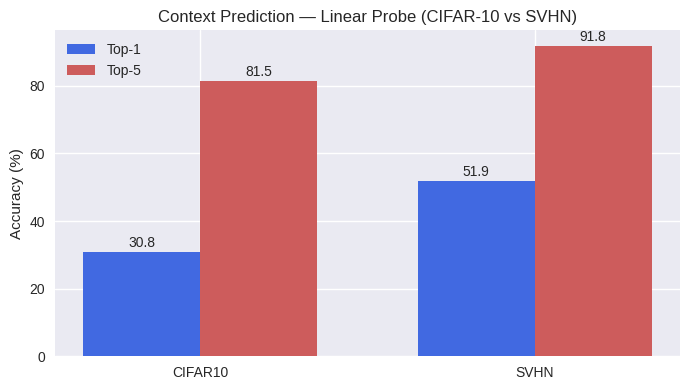

In [34]:
df_cp = run_context_prediction_on_two_datasets()